### Домашнее задание
1) обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта.

2) при обучении моделей обязательно использовать кроссвалидацию

3) вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)

4) сделать выводы о том, какая модель справилась с задачей лучше других


Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from catboost import CatBoostClassifier


%matplotlib inline

In [2]:
#Функции и классы для заданий
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
#Функция показа ROC кривой
def show_roc_curve(y_test, y_pred):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_pred, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.show()

In [6]:
#Функция валидации модели
rubl_test = 1400
rubl_early_treatment = 15000
rubl_late_treatment = 20000

def validate_model(model, X_train, X_test, y_train, y_test):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)

    # обучение модели и предсказание
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]

    # поиск оптимальной границы
    beta = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_pred)
    f1 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    ix = np.argmax(f1)

    # отрисовка кривой roc auc
    show_roc_curve(y_test, y_pred)

    # оценка бизнес метрик
    cnf_matrix = confusion_matrix(y_test, y_pred > thresholds[ix])

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP / (TP+FN)
    FPR = FP / (FP+TN)
    TNR = TN / (FP+TN)

    rubl_without_test = (FN + TP) * rubl_late_treatment
    rubl_ML = (FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment
    rubl_test_all = np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment

    # Return metrics
    return {'precision': precision[ix],
            'recall': recall[ix],
            'f1_score': f1[ix],
            'roc_auc': roc_auc_score(y_test, y_pred),
            'cv_roc_auc': cv_score,
            'cv_roc_auc_std': cv_score_std,
            'rubl_late_treatment':(FN + TP) * rubl_late_treatment,
            'rubl_test_all':np.sum(cnf_matrix) * rubl_test + (FN + TP) * rubl_early_treatment,
            'rubl_ML':(FP + TP) * rubl_test + FN * rubl_late_treatment + TP * rubl_early_treatment,
            'rubl_without_test - rubl_ML':rubl_without_test - rubl_ML,
            'rubl_without_test - rubl_test_all':rubl_without_test - rubl_test_all,
            'rubl_test_all - rubl_ML':rubl_test_all - rubl_ML
            }

Работа с данными

In [7]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

C:\Users\77015\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [8]:
#Делим датасет
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['cardio']), 
                                                    df['cardio'],
                                                    random_state=0)

In [9]:
#Пайплайны трансформаций
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

# Объединяем пайплайны признаков в один
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)    

In [11]:
#результаты сравнения моделей
final_board_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'roc_auc', 'cv_roc_auc', 'cv_roc_auc_std'])

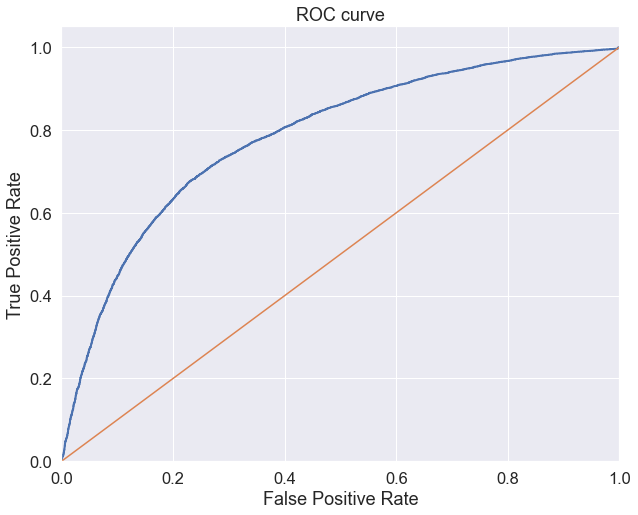

C:\Users\77015\AppData\Local\Temp\ipykernel_25888\3444167772.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_board_df = final_board_df.append(model_metrics, ignore_index=True)


In [12]:
#Логистическая регрессия
clf_LR = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=42)),
])

model_metrics = validate_model(clf_LR, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

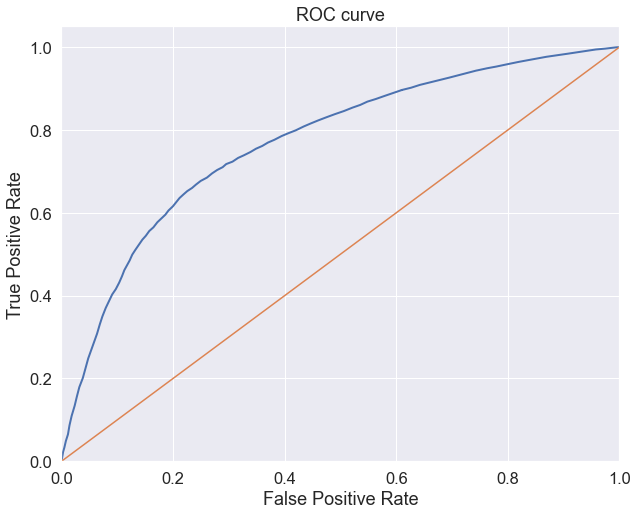

C:\Users\77015\AppData\Local\Temp\ipykernel_25888\643457937.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_board_df = final_board_df.append(model_metrics, ignore_index=True)


In [13]:
#Случайный лес
clf_RFC = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])


model_metrics = validate_model(clf_RFC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

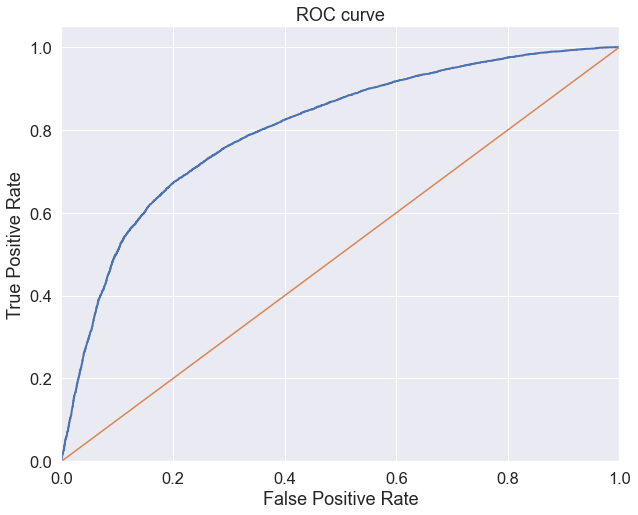

C:\Users\77015\AppData\Local\Temp\ipykernel_25888\1804233440.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_board_df = final_board_df.append(model_metrics, ignore_index=True)


In [14]:
#Градиентный бустинг
clf_GBC = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=42)),
])

model_metrics = validate_model(clf_GBC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

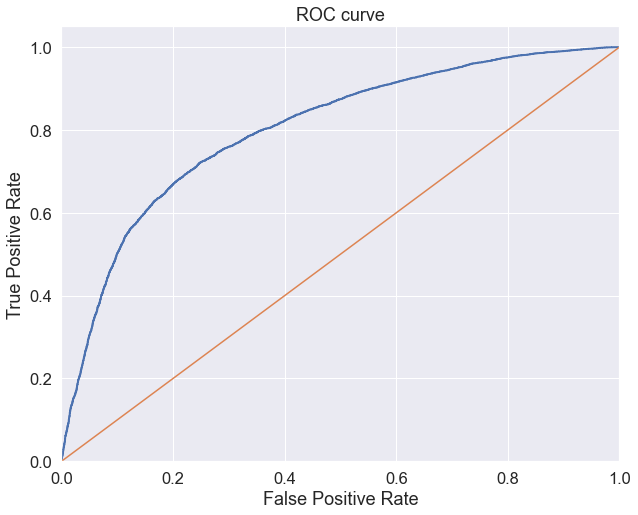

C:\Users\77015\AppData\Local\Temp\ipykernel_25888\1652024494.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_board_df = final_board_df.append(model_metrics, ignore_index=True)


In [15]:
#Градиентный бустинг (CatBoost)
clf_CBC = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(random_state=42, verbose=False)),
])

model_metrics = validate_model(clf_CBC, X_train, X_test, y_train, y_test)
final_board_df = final_board_df.append(model_metrics, ignore_index=True)

In [16]:
#Метрики
final_board_df

,precision,recall,f1_score,roc_auc,cv_roc_auc,cv_roc_auc_std,rubl_ML,rubl_late_treatment,rubl_test_all,rubl_test_all - rubl_ML,rubl_without_test - rubl_ML,rubl_without_test - rubl_test_all
0,0.647431,0.837558,0.730323,0.784035,0.78645,0.004705,152974200.0,173600000.0,154700000.0,1725800.0,20625800.0,18900000.0
1,0.642669,0.815553,0.718863,0.771037,0.774612,0.002827,153699400.0,173600000.0,154700000.0,1000600.0,19900600.0,18900000.0
2,0.697848,0.788134,0.740248,0.802615,0.802095,0.003615,153122800.0,173600000.0,154700000.0,1577200.0,20477200.0,18900000.0
3,0.689236,0.797465,0.739411,0.801387,0.801247,0.004232,153053800.0,173600000.0,154700000.0,1646200.0,20546200.0,18900000.0


Модель градиентного бустинга справилась лучше остальных по всем метрикам, кроме recall. Если метрика recall важен, то лучше использовать Логистическую регрессию так как он показал себя лучше остальных, если нет то в лучше градиентный бустинг.

По поводу бизнес-показателей видно, что модель логистической регрессии экономит значительно больше денег в случае теста, но не так значительно в случае отмены тестирования. В промежуточных вариантах тоже выгоднее прислушаться к данным именно этой модели.